## 3. Understanding Ensembles (5 points (3+2))
Do a deeper analysis of how RandomForests and Gradient Boosting reduce their prediction error. We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). When high-energy particles hit the atmosphere, they produce chain reactions of other particles called 'showers', and you need to detect whether these are caused by gamma rays or cosmic rays.

In [3]:
# Get the data
import openml as oml
magic_data = oml.datasets.get_dataset(1120) # Download MAGIC Telescope data
X, y = magic_data.get_data(target=magic_data.default_target_attribute);

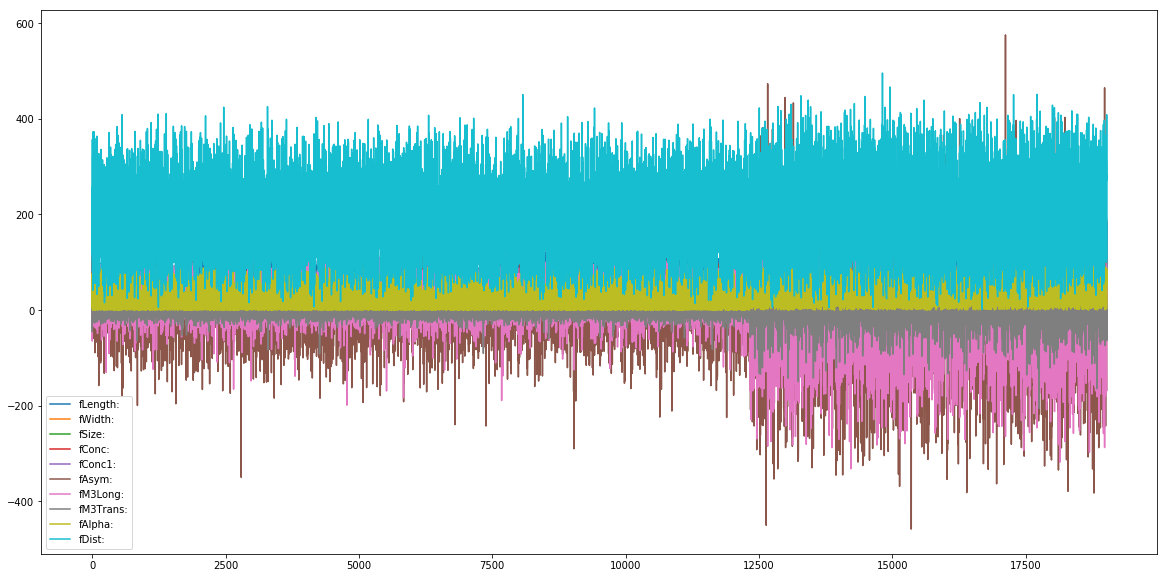

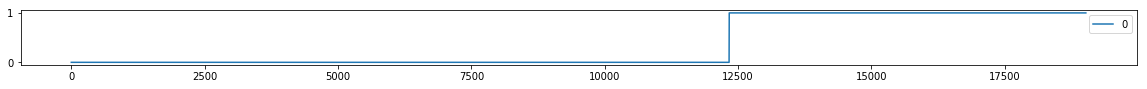

In [6]:
# Quick visualization
import pandas as pd
X, y, attribute_names = magic_data.get_data(target=magic_data.default_target_attribute, return_attribute_names=True)
magic = pd.DataFrame(X, columns=attribute_names)
magic.plot(figsize=(20,10))
# Also plot the target: 1 = gamma, 0 = background
pd.DataFrame(y).plot(figsize=(20,1));

1 . Do a bias-variance analysis of both algorithms. For each, vary the number of trees on a log scale from 1 to 1024, and plot the bias error (squared), variance, and total error (in one plot per algorithm). Interpret the results. Which error is highest for small ensembles, and which reduced most by each algorithm as you use a larger ensemble? When are both algorithms under- or overfitting? Provide a detailed explanation of why random forests and gradient boosting behave this way.
- See lecture 3 for an example on how to do the bias-variance decomposition
- To save time, you can use a 10% stratified subsample in your initial experiments, but show the plots for the full dataset in your report.

In [27]:

#Bias-Variance analysis on Random Forest. 
#Ran on Pycharm. 

##Bias variance analysis
#xlog = np.logspace(1, 1024, 3, endpoint=True)
xlog =[1,10,100,1000]

Ntrees=xlog[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

forest = RandomForestClassifier(n_estimators=Ntrees, random_state=2)


# Bootstraps
n_repeat = 100
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

# Store sample predictions
y_all_pred = [[] for _ in range(len(y))]

# Train classifier on each bootstrap and score predictions
for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
    # Train and predict
    forest.fit(X[train_index], y[train_index])
    y_pred = forest.predict(X[test_index])

    # Store predictions
    for i, index in enumerate(test_index):
        y_all_pred[index].append(y_pred[i])

# Compute bias, variance, error
bias_sq = sum([(1 - x.count(y[i]) / len(x)) ** 2 * len(x) / n_repeat
               for i, x in enumerate(y_all_pred)])
var = sum([((1 - ((x.count(0) / len(x)) ** 2 + (x.count(1) / len(x)) ** 2)) / 2) * len(x) / n_repeat
           for i, x in enumerate(y_all_pred)])
error = sum([(1 - x.count(y[i]) / len(x)) * len(x) / n_repeat
             for i, x in enumerate(y_all_pred)])

print("Bias squared: %.2f, Variance: %.2f, Total error: %.2f" % (bias_sq, var, error))

Bias_RF=[581.35, 614.33,650.14,673.18]
V_RF=[671.58, 223.72, 106.02,82.38]
T_RF=[1252.93, 838.05, 756.16,755.56]


<generator object _BaseKFold.split at 0x7f3601c8b570>

Text(0.5,1,'Performance vs #Trees in Random Forests')

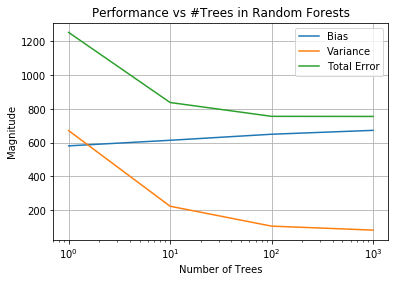

In [30]:
import matplotlib.pyplot as plt
xlog =[1,10,100,1000]

Bias_RF=[581.35, 614.33,650.14,673.18]
V_RF=[671.58, 223.72, 106.02,82.38]
T_RF=[1252.93, 838.05, 756.16,755.56]


p1=plt.plot(xlog,Bias_RF)
p2=plt.plot(xlog,V_RF)
p3=plt.plot(xlog,T_RF)
plt.grid()
plt.xscale('log')

plt.legend((p1[0], p2[0], p3[0]), ('Bias', 'Variance','Total Error'))

plt.ylabel('Magnitude')
plt.xlabel('Number of Trees')
plt.title('Performance vs #Trees in Random Forests')


Text(0.5,1,'Performance vs #Elements in Gradient Boosting')

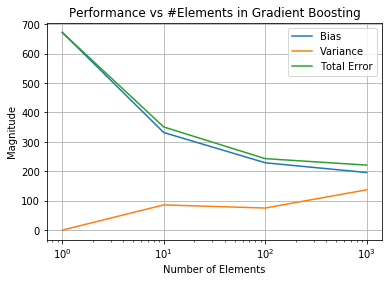

In [33]:
import matplotlib.pyplot as plt
xlog =[1,10,100,1000]

Bias_RF=[672.13, 331.80,228.97,195.85]
V_RF=[0.00,  85.73, 75.10,137.06]
T_RF=[672.13, 350.69, 243.05,221.06]

p1=plt.plot(xlog,Bias_RF)
p2=plt.plot(xlog,V_RF)
p3=plt.plot(xlog,T_RF)
plt.grid()
plt.xscale('log')

plt.legend((p1[0], p2[0], p3[0]), ('Bias', 'Variance','Total Error'))

plt.ylabel('Magnitude')
plt.xlabel('Number of Elements')
plt.title('Performance vs #Elements in Gradient Boosting')

Random Forest's error was the highest for small ensambles.  

As a larger ensemble is used in Random Forest, the error due to variance is reduced given that the variance reduces as well.
On the other hand, the error due to Bias is reduced on Gradient Boosting when increasing the ensembles. 

The models overfit when the variance is highest, this occurs when Random Forests uses a small number of ensembles and when Gradient Boosting uses a high number of elements. 
The models underfit when the bias is high, which occurs when Random Forests uses a high number of ensembles and when Gradient Boosting uses a small number of ensembles. 

Boosting uses learners equivalent to shallow trees, mainly reducing bias. 
On the other hand, Random Forest uses more complex trees (high variance) and works reducing variance. 




2 . A _validation curve_ can help you understand when a model starts under- or overfitting. It plots both training and test set error as you change certain characteristics of your model, e.g. one or more hyperparameters. Build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. In addition, use at least two values for the learning rate (e.g. 0.1 and 1), and tree depth (e.g. 1 and 4). This will yield at least 4 curves. Interpret the results and provide a clear explanation for the results. When is the model over- or underfitting? Discuss the effect of the different combinations learning rate and tree depth and provide a clear explanation.
- While scikit-learn has a `validation_curve` function, we'll use a modified version (below) that provides a lot more detail and can be used to study more than one hyperparameter. You can use a default train-test split.

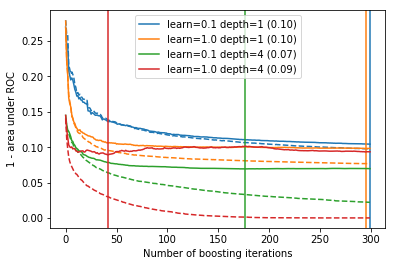

In [67]:
# Plots validation curves for every classifier in clfs. 
# Also indicates the optimal result by a vertical line
# Uses 1-AUROC, so lower is better
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score



def validation_curve(clf, X_test, y_test, X_train, y_train):
    for n,clf in enumerate(clf):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score,
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')
    
    
g1=GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=1).fit(X_train, y_train)    
g2=GradientBoostingClassifier(n_estimators=300, learning_rate=1, max_depth=1).fit(X_train, y_train)    
g3=GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=4).fit(X_train, y_train)    
g4=GradientBoostingClassifier(n_estimators=300, learning_rate=1, max_depth=4).fit(X_train, y_train)    




clfs=[g1,g2,g3,g4]
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
validation_curve(clfs, X_test, y_test, X_train, y_train)


If two curves are "close to each other" and both of them but have a low score. The model suffer from an under fitting problem (
Overfitting occurs when the test and the training scores are very far away, such as the green lines on the plot. 
The comparison between the green and the blue lines show that increasing the depth leads to overfitting after many iterations. 
A higher learning rate decreases the area under the curves. In summary the best is to use a lower learning rate and a lower depth when using a small number of iterations. 